In [1]:
# Imports for this project
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils import data
from tqdm import tqdm

In [2]:
# Grab the MNIST dataset
training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testing_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

tfm = transforms.Compose([
    transforms.ToTensor(),
])

trainset_full_CIFAR10 = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
testset_full_CIFAR10  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)

In [3]:
# Verify that GPU is connected and available

print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'The system GPU | {torch.cuda.get_device_name(0) if not None else 'Error'} | is {'AVAILABLE' if torch.cuda.is_available() else 'NOT AVAILABLE' }')

2.6.0+cu124
The system GPU | NVIDIA GeForce RTX 4060 Laptop GPU | is AVAILABLE


### Problem 1: Consider training an auto-encoder model on the MNIST data, with three hidden layers (so that the encoder and decoder both have one hidden layer). Note, the input layer and final output layer need to be 784 dimensional. Let the middle hidden layer be of size k (we will change k), and the first and third hidden layer as large as you see fit to get good results (probably need to be more than 784 dimensional). Plot, as a function of k, the mean test and training reconstruction losses. What does this tell you about the ‘dimension’ of the MNIST data set, compared to its ‘raw’ dimension of 784?

#### Bonus: How does this compare to a PCA analysis of the dimensionality of the MNIST data set?
#### Bonus: Demonstrate whether or not Dropout is useful here, and explain why

In [9]:
class MNIST_Auto_Encoder(nn.Module):
    def __init__(self, bottleneck, hidden_layer_size=784, p=0):
        super().__init__()
        
        # Defined number of features for the image
        input_size=784

        # Encoder section
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_layer_size), # Input to hidden
            nn.Dropout(p=p),
            nn.ReLU(inplace=True),                                             # Activation Function
            nn.Linear(in_features=hidden_layer_size, out_features=bottleneck)  # Hidden to bottleneck
        )

        # Decoder Section
        self.decoder = nn.Sequential(
            nn.Linear(in_features=bottleneck, out_features=hidden_layer_size), # Bottleneck to hidden
            nn.ReLU(inplace=True),                                             # Activation Function
            nn.Dropout(p=p),
            nn.Linear(in_features=hidden_layer_size, out_features=input_size), # Hidden to output
            # nn.Sigmoid()                                           # Force output pixels to be between 0 and 1
        )

    def forward(self, x) -> torch.Tensor:
        
        # Extract batch size and resize input into the nn
        batch_size = x.size(0)
        x_flattened = x.view(batch_size, -1)

        # Encode then decode the input
        x_encoded = self.encoder(x_flattened)
        x_decoded = self.decoder(x_encoded)

        # Reshape decoded x for final result
        x_predicted = x_decoded.view(batch_size, 1, 28, 28)
        
        return x_predicted
        

In [10]:
# Store the data for this test
k_over_training_loss = []
k_over_testing_loss = [] 


epoch_over_training_loss = []
epoch_over_testing_loss = []

'''
Data for the graph will be in the form of
{
    k: int
    final_training/testing_loss: float
}
'''

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
# Model hyperparameters
epochs = 10
batch_size = 64
learning_rate = 1e-1

# Question specific hyperparameters
hidden_layer_size = 5000
k_start = 40
k_end = 0
k_step = -50

# Loop through each bottlenec5ks
for k in range(k_start, k_end, k_step):
    
    print(f'########## With bottleneck = {k} ############')
    
    train_loader = data.DataLoader(training_set, 
                                    batch_size=batch_size, 
                                    shuffle=True,
                                    num_workers=5, 
                                    pin_memory=True
                               )
    
    test_loader = data.DataLoader(testing_set, 
                                    batch_size=batch_size, 
                                    shuffle=False,
                                    num_workers=5, 
                                    pin_memory=True
                               )

    model = MNIST_Auto_Encoder(k, hidden_layer_size=hidden_layer_size)
    model.to(device)

    total_params, trainable_params = count_parameters(model)

    print(f' ~~ Total/Trainable Parameters: {total_params}')

    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Have references to variables outside of the epoch loop
    avg_training_loss = 0
    avg_testing_loss = 0

    print(model)

    # Epoch Loop
    for epoch in range(epochs):
        print(f'----- Epoch: {epoch + 1}/{epochs} -----')

        # Per epoch reset accumulated loss
        avg_training_loss = 0
        avg_testing_loss = 0

        # Run through each batch
        for images, _ in tqdm(train_loader, desc='Training', unit=' batch'):
            # Move data into the GPU
            images = images.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Calc loss
            generated_images = model(images)
            loss = loss_function(generated_images, images)

            # Calc gradient and step
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                avg_training_loss += loss.item()

        # Set up for calculating testing loss
        avg_training_loss /=  len(train_loader)

        model.eval()

        # Calc training loss
        with torch.no_grad():
            for test_images, _ in tqdm(test_loader, desc='Testing', unit=' batch'):
                test_images = test_images.to(device)
                generated_test_images = model(test_images)
                
                avg_testing_loss += loss_function(generated_test_images, test_images).item()

        avg_testing_loss /=  len(test_loader)

        model.train()
        
        epoch_over_training_loss.append({
            "k": k,
            "epoch": epoch,
            "training_loss": avg_training_loss
        })

        epoch_over_testing_loss.append({
            "k": k,
            "epoch": epoch,
            "testing_loss": avg_testing_loss
        })

        print("")

        print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
        print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

    # Add end results to the lists
    k_over_training_loss.append({
        "k": k,
        "training_loss": avg_training_loss 
    })

    k_over_testing_loss.append({
        "k": k,
        "testing_loss": avg_testing_loss
    })

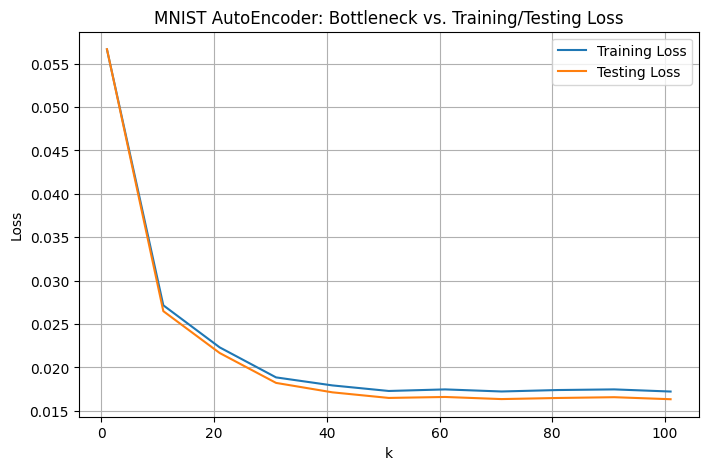

In [14]:
ks = [d["k"] for d in k_over_training_loss]
train_loss = [d["training_loss"] for d in k_over_training_loss]
test_loss = [d["testing_loss"] for d in k_over_testing_loss]

plt.figure(figsize=(8, 5))
plt.plot(ks, train_loss, label="Training Loss")
plt.plot(ks, test_loss, label="Testing Loss")
plt.xlabel("k")
plt.ylabel("Loss")
plt.title("MNIST AutoEncoder: Bottleneck vs. Training/Testing Loss")
plt.legend()
plt.grid(True)
plt.show()

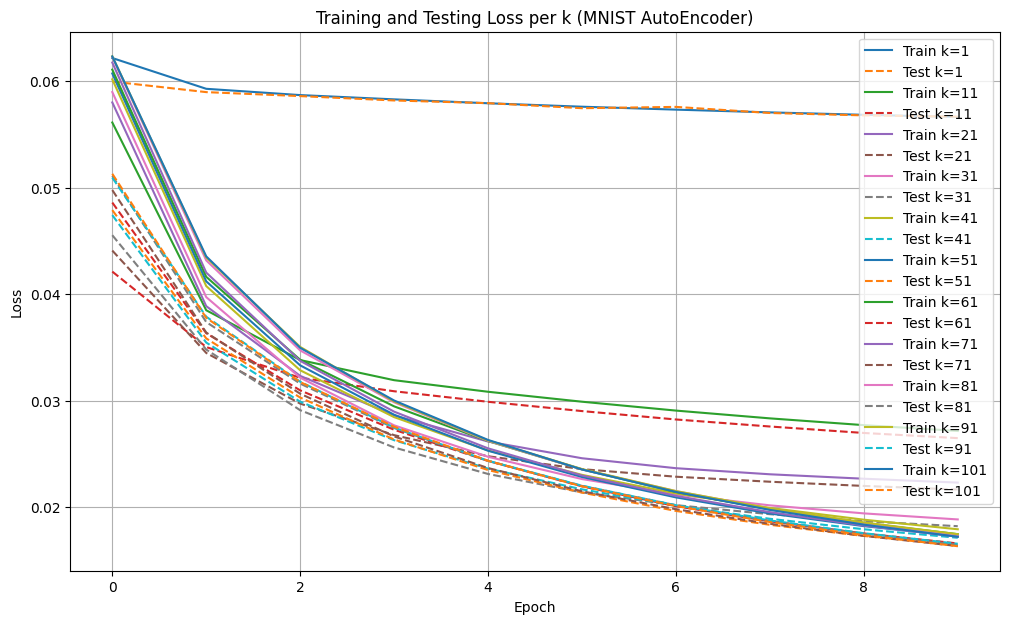

In [15]:
# Get all unique k values
ks = sorted(set(d["k"] for d in epoch_over_training_loss))

plt.figure(figsize=(12, 7))
for k in ks:
    # Get epochs and losses for this k
    epochs = [d["epoch"] for d in epoch_over_training_loss if d["k"] == k]
    train_loss = [d["training_loss"] for d in epoch_over_training_loss if d["k"] == k]
    test_loss = [d["testing_loss"] for d in epoch_over_testing_loss if d["k"] == k]
    
    plt.plot(epochs, train_loss, label=f"Train k={k}")
    plt.plot(epochs, test_loss, '--', label=f"Test k={k}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss per k (MNIST AutoEncoder)")
plt.legend()
plt.grid(True)
plt.show()

#### Model Architecture

For the Autoencoder, were are forced to only have one linear layer for both the encoder and decoder. With this constraint, I decided that it would be best to use a lot of nodes per layer in order to minimize my loss. Moreover, I also wanted to use a number of nodes that I could actually train the model on in a reasonable amount of time, so I chose to go with 5000 nodes per hidden layer.

#### Initial Training 

For the hyperparameters I chose, I decided to keep my hyperparameters standard with epochs = 10, batch_size = 64, learning_rate = 0.1. I believed using these would be more than reasonable to see the effects of changing the bottleneck while still getting a good enough autoencoder. After the first training batch of the model on all k's (101 through 1 with step size 10), I noticed that the model never overfitted at any epoch for any k and all of the final testing losses were very low.

#### Graph Analysis

Looking at the graph, we can see k and training/testing losses share a relationship similar to the right half of the function $y = \frac{1}{x}$. As expected, when you decrease the size of the bottleneck, the final testing loss should start to increase as it gets harder and harder to make a meaningful mapping of an image in lower dimensionality. Yet, we notice that the growth of the final training loss is very slow from k = 40 to 100 and at k = 40 it is the lowest point before the loss start to shoot off. As such, I would say that a better dimensionality of the MNIST dataset image would actually be around 40 or around 6x6 for each image. An interesting observation that I made was that even at k = 1, the overall final loss was only 0.06 meaning we are able to get a pretty good encoding of an MNIST image as a single value.

### Problem 2: For the optimal k, let Ftrained be the trained encoder from the previous section, and Funtrained be a model of the same structure with randomly initialized weights. Compare the results of training a classification model


#### Classify(x) = softmax(AF (x) + b)
#### i.e., a simple linear softmax layer placed on top of the output of F , in the following cases:

- With F starting as randomly initialized, training the full Classify(x) model.
- With F starting as the trained encoder from the previous problem, training only the weights in the last linear layer.
- With F starting as randomly initialized, training only the weights in the last linear layer.
- With F starting as the trained encoder model from the previous problem, training the full Classify(x) model.

####  What do you notice about both the quality of the results you get, and the amount of work needed to achieve those results? Be sure to keep track of testing loss as well, and avoid overfitting.


##### Note: When treating F as the trained auto-encoder, do not factor in the training time of this model - the idea is that we could potentially re-use trained models, or make use of someone else’s work, to reduce our own labor.

In [24]:
class MNIST_Classifier(MNIST_Auto_Encoder):

    def __init__(self, k, hidden_layer_size):
        super().__init__(k, hidden_layer_size)

        self.output_layer = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(in_features=k, out_features=10)
        )

    def forward(self, x):
        
        batch_size = x.size(0)
        x_flattened = x.view(batch_size, -1)

        x_flattened = self.encoder(x_flattened)
        logits = self.output_layer(x_flattened)

        return logits

In [25]:
def freeze_module(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_module(m):
    for p in m.parameters():
        p.requires_grad = True

epoch_over_training_loss_per_model = []
epoch_over_testing_loss_per_model = []

'''
For of the data will be....

data = {
    epoch: int
    training/testing loss: float
    model_name: str
}
'''

'\nFor of the data will be....\n\ndata = {\n    epoch: int\n    training/testing loss: float\n    model_name: str\n}\n'

In [26]:
optimal_k = 40

# Have reference
src_model = model

# 1. Untrained encoder not frozen
encoder_clean_unfrozen = MNIST_Classifier(optimal_k, hidden_layer_size=hidden_layer_size).to(device)

# 2. Untrained encoder but frozen
encoder_clean_frozen = MNIST_Classifier(optimal_k, hidden_layer_size=hidden_layer_size).to(device)
freeze_module(encoder_clean_frozen.encoder)

# 3. Trained encoder not frozen
encoder_trained_unfrozen = MNIST_Classifier(optimal_k, hidden_layer_size=hidden_layer_size).to(device)
encoder_trained_unfrozen.encoder.load_state_dict(src_model.encoder.state_dict())

# 4. Trained encoder but frozen
encoder_trained_frozen = MNIST_Classifier(optimal_k, hidden_layer_size=hidden_layer_size).to(device)
encoder_trained_frozen.encoder.load_state_dict(src_model.encoder.state_dict())

freeze_module(encoder_trained_frozen.encoder)

models = [encoder_clean_unfrozen, encoder_clean_frozen, encoder_trained_unfrozen, encoder_trained_frozen]



In [27]:
m1_learning_rate = 7.5e-5
m2_learning_rate = 1e-3
m3_learning_rate = 7.5e-5
m4_learning_rate = 1e-3

lrs = [m1_learning_rate, m2_learning_rate, m3_learning_rate, m4_learning_rate]

In [ ]:
# Model hyperparameters
epochs = 10
batch_size = 64


print(f'######## Begin Training Encoders on bottleneck={optimal_k} ########')

train_loader = data.DataLoader(training_set, 
                                batch_size=batch_size, 
                                shuffle=True,
                                num_workers=5, 
                                pin_memory=True
                            )

test_loader = data.DataLoader(testing_set, 
                                batch_size=batch_size, 
                                shuffle=False,
                                num_workers=5, 
                                pin_memory=True
                            )

for sample_model, model_name, learning_rate in zip(models, ['Unfrozen Clean Encoder', 'Frozen Clean Encoder', 'Unfrozen Pretrained Encoder', 'Frozen Pretrained Encoder'], lrs):

    print(f'@@@@@@ Training {model_name} using learning rate = {learning_rate} @@@@@@')

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(sample_model.parameters(), lr=learning_rate)

    avg_training_loss = 0
    avg_testing_loss = 0

    sample_model.train()

    for epoch in range(epochs):
        print(f'----- Epoch: {epoch + 1}/{epochs} -----')

        # Per epoch reset accumulated loss
        avg_training_loss = 0
        avg_testing_loss = 0

        # Run through each batch
        for images, labels in tqdm(train_loader, desc='Training', unit=' batch'):
            # Move data into the GPU
            images = images.to(device)
            labels = labels.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Calc loss
            logits = sample_model(images)
            loss = loss_function(logits, labels)

            # Calc gradient and step
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                avg_training_loss += loss.item()

        # Set up for calculating testing loss
        avg_training_loss /=  len(train_loader)

        sample_model.eval()

        # Calc training loss
        with torch.no_grad():
            for test_images, labels in tqdm(test_loader, desc='Testing', unit=' batch'):
                test_images = test_images.to(device)
                labels = labels.to(device)
                logits = sample_model(test_images)
                
                avg_testing_loss += loss_function(logits, labels).item()

        avg_testing_loss /=  len(test_loader)

        sample_model.train()
        
        print("")

        print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
        print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

        # Add end results to the lists
        epoch_over_training_loss_per_model.append({
            "epoch": epoch,
            "training_loss": avg_training_loss,
            "model_name": model_name
        })

        epoch_over_testing_loss_per_model.append({
            "epoch": epoch,
            "testing_loss": avg_testing_loss,
            "model_name": model_name
        })

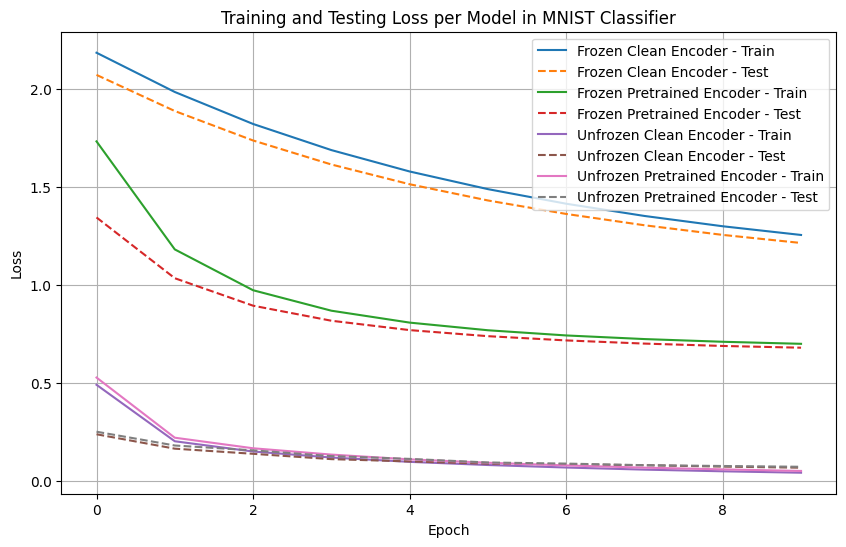

In [29]:
plt.figure(figsize=(10, 6))
model_names = sorted(set(d["model_name"] for d in epoch_over_training_loss_per_model))
for name in model_names:
    epochs = [d["epoch"] for d in epoch_over_training_loss_per_model if d["model_name"] == name]
    train_loss = [d["training_loss"] for d in epoch_over_training_loss_per_model if d["model_name"] == name]
    test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_per_model if d["model_name"] == name]
    plt.plot(epochs, train_loss, label=f"{name} - Train")
    plt.plot(epochs, test_loss, '--', label=f"{name} - Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Testing Loss per Model in MNIST Classifier")
plt.legend()
plt.grid(True)
plt.show()

#### Results

Frozen Clean Enocder Final Testing Loss: Around 1.25

Frozen Pretrained Enocder Final Testing Loss: Around 0.70

Unfrozen Clean Enocder Final Testing Loss: Around 0.68

Unfrozen Pretrained Enocder Final Testing Loss: Around 0.68

#### Graph Analysis

From the graph, we can see that using the pretrained encoder from Question 1's model helped give lower losses for Question 2's model. This can be seen with the pretrained model achieving half as low of a final testing loss as compared to the clean model in the frozen layers category. However, in the unfrozen layers section, it can be observed that pretrained and clean models both get nearly identical final testing losses. The reason why I believe this happened was because both because the task was a bit simple and the models used in general were too small, in terms of number of layers. Furthermore, the fact that freezing mostly all of the model was the only way to see the benefit of transfer learning helps reinforce my assumption. Yet, I do not believe that transfer learning is a waste of time. Comparing the frozen models, pretraining allowed us to immediatly beat the untrained model's loss at the 10th epoch in the 1st epoch. Though time was not saved in the case of the unfrozen models, if the task was more challenging, I could see transfer learning giving us the same time saving.

#### Hyperparameter Search

For each model, I decided to give them their own learning rates in order to train each individual model and achieve best results. First, I gave every model a learning rate of 1e-2. On my initial training run, I noticed that every model began to overtrain after the first epoch, so I decided to give more thinking into the learning rates for each model. Since I would technically want to keep the weights in the unfrozen transfer-learned model as close to the original as possible, it would be wise to keep the learning rate lower than the rest. For the other models, finetunning the initial 1e-2 would be better since the untrained models need to be able to learn, and the frozen transfer-learned model only trains on the last layer.

For the second loop, I decided to use learning rates of 1e-3, 1e-3, 1e-3, and 5e-4 where the last rate was for the unfrozen transfer-learned model. This time, none of the models overtrainned meaning my conclusions from earlier were corrected. Specifically, the frozen untrained model got a testing loss of around 1.4 which was beat by the pretrained frozen model loss of around 0.75. Moreover, the testing losses of the unfrozen models were around 0.1. However, I did noticed that both of the unfrozen models had testing losses that were only slightly greater than their respective training losses, 

In the third attempt, I decided to adjust both of the unfrozen model learning rates to 1e-4 which successfully mitigated this issue of slight overtraining till the 4th epoch. Both of these models had a testing loss around 0.08.

Finally, I decided to adjust the unfrozen model learning rates both to 7.5e-5 just to see if I can get the testing and training accuracies any lower and closer which actually worked. Both of the unfrozen models were able to get final testing losses close to 0.68.

### Problem 3: Build and train a network for classifying CIFAR, with at least 5 layers, and at least one of them being a CNN layer. Your goal should be good performance, so keep track of the testing loss as you do

In [17]:
class CIFAR10_Classifier(nn.Module):
    def __init__(self, C_dropout, F_dropout):
        super().__init__()

        conv2d_dropout = C_dropout

        conv_layer_1 = 30
        conv_layer_2 = 64
        
        conv_layer_3 = 128
        conv_layer_4 = 256

        self.forward_funnel_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_layer_1, kernel_size=5),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_1, out_channels=conv_layer_2, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),                       # Reduce dimensionality
        )

        self.forward_funnel_2 = nn.Sequential(
            nn.Conv2d(in_channels=conv_layer_2, out_channels=conv_layer_3, kernel_size=3),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_3, out_channels=conv_layer_4, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Compute the number of features after the input has passed the funnel
        with torch.no_grad():
            test_input = torch.zeros(1, 3, 32, 32)

            test_input.to(device)

            features = self.forward_funnel_1(test_input)
            features = self.forward_funnel_2(features)

            total_count = features.view(1, -1).size(1)

        full_node_dropout = F_dropout
        self.output_nodes = 100

        self.classifer = nn.Sequential(
            nn.Flatten(),                                           # Flatten the image from the funnel
            nn.Linear(in_features=total_count, out_features=1000), 
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=500, out_features=250),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=250, out_features=self.output_nodes),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),
        )

        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=10)
    
    def partial_forward(self, x):
        x = self.forward_funnel_1(x)
        x = self.forward_funnel_2(x)
        x = self.classifer(x)

        return x

    def forward(self, x):
        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits


In [118]:
epoch_over_training_loss_CIFAR10 = []
epoch_over_testing_loss_CIFAR10 = []

'''
Form of the data

data = 
{
    epoch: int
    training/testing loss: float
}
'''

'\nForm of the data\n\ndata = \n{\n    epoch: int\n    training/testing loss: float\n}\n'

In [ ]:
# Hyperparameter setup
epochs = 15
batch_size = 64
learning_rate = 5e-4
decay_rate = 4e-4

c_dropout = 0.25
f_dropout = 0.25

print('######## Begining training for CIFAR10 classifier ##########')

# Setup data loaders
trainset_loader_CIFAR10 = data.DataLoader(trainset_full_CIFAR10,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   # num_workers=5,
                                   pin_memory=True)

testset_loader_CIFAR10 = data.DataLoader(testset_full_CIFAR10,
                                   batch_size=batch_size,
                                   # num_workers=5,
                                   shuffle=False,
                                   pin_memory=True)

model = CIFAR10_Classifier(c_dropout, f_dropout)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=decay_rate
                       )

# Have references to variables outside of the epoch loop
avg_training_loss = 0
avg_testing_loss = 0

# Epoch Loop
for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')
    
    avg_training_loss = 0
    avg_testing_loss = 0

    model.train()

    for x, Y in tqdm(trainset_loader_CIFAR10, desc='Training', unit=' batch'):
        # Transfer images to GPU
        x = x.to(device)
        Y = Y.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Send images to model
        x_pred = model(x)

        # Calc loss
        loss = loss_function(x_pred, Y)

        # Calc gradient and update weights
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_training_loss += loss.item()

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        for x, Y in tqdm(testset_loader_CIFAR10, desc='Testing', unit=' batches'):
            # Move the images to the GPU
            x = x.to(device)
            Y = Y.to(device)

            # Get logits and sum up total loss
            x_pred = model(x)
            avg_testing_loss += loss_function(x_pred, Y).item()

    # Get training loss
    avg_training_loss /= len(trainset_loader_CIFAR10)

     # Get testing loss
    avg_testing_loss /= len(testset_loader_CIFAR10)

    # Switch model back to training mode
    model.train()

    epoch_over_training_loss_CIFAR10.append({
        "epoch": epoch,
        "training_loss": avg_training_loss
        })
    
    epoch_over_testing_loss_CIFAR10.append({
        "epoch": epoch,
        "testing_loss": avg_testing_loss
        })
    

    print("")

    print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
    print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')


Final Accuracy: 0.7297


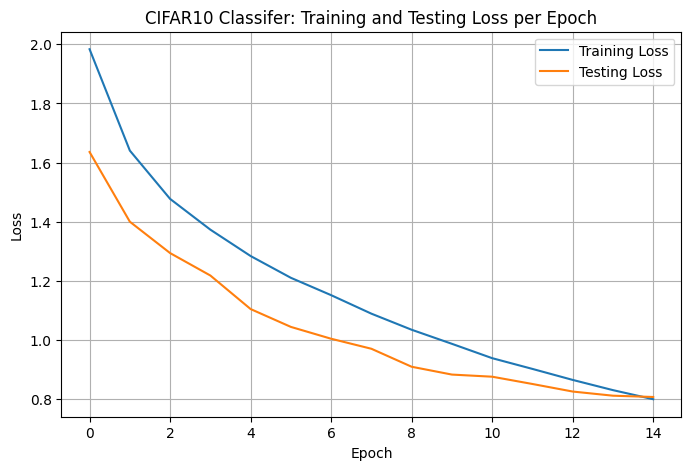

In [ ]:
model.eval()

correct = total = 0

with torch.no_grad():
    for xb, yb in testset_loader_CIFAR10:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

final_accuracy = float(correct / total)

print(f"Final Accuracy: {final_accuracy}")

epochs = [d["epoch"]for d in epoch_over_training_loss_CIFAR10]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Classifer: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Results 

Testing Accuracy: 72.97%

Training Loss: 0.7996

Testing Loss: 0.8072

#### Final Model Hyperparameters

epochs = 15

batch_size = 64

learning_rate = 5e-4

decay_rate = 4e-4

c_dropout = 0.25

f_dropout = 0.25


#### Model Architecture 1

In the beginning, I decided that I wanted to have two convolutional layers, one that extracted a lot of features from the image data and one that found more advanced features. Since the first layer would find as many initial features to start, I decided to make the out channel 128 and kernel size 5x5. Then, the second layer would condense those features, so I chose an out channel size of 64 and kernel size of 3x3. Additionally, I stacked 4 decreasing, funneling, fully-connected layers, 1000 -> 1000 -> 500 -> 100, that finally connected to the output layer. My reasoning was that doing this would allow me to find complex features that would become more and more concentrated and meaningful. Finally, I added a max pooling layer after the convolutional layers to help reduce dimensionality of the data and dropout layers after every layer to prevent overfitting. 

#### Optimizer
I went with Adam since I wanted to experiment with using different options. Furthermore, I wanted my loss to be as low as possible, so I wanted to use weight decay. As such, the final optimizer I used was AdamW since it handles weight decay better.

#### Initial training

I started with initial hyperparamters of batch_size = 64, learning_rate = 1e-3, decay_rate = 5e-4 (weight decay), c_dropout = 0.40 (the dropout probability for each convolutional layer), and f_dropout = 0.60 (the dropout probability for each fully-connected layer). After the first training, I noticed that my losses were not really good for this data set, training loss ~= 1.3 and testing loss ~= 1.25. Specially, they could never get past the 1.2 barrier and started to stagnate at the 14th epoch. Since I did not think overfitting was an issue yet, I decided to tweak the learning rate from 1e-3 to 5e-4.

In the second trial, I noticed that the issue of the model not being able to learn was still present, losses similar to the first trial, so I thought the maybe my dropout p's were a bit too high. This caused me to set both of them to 0.4.

In my next training attempt, I saw I was able to break past the 1.2 loss barrier by the 10th epoch which solidified my reasoning that my p's were too high, but I was unable to get a testing loss lower than ~1.10 after the 15th epoch. However, I did notice that model was still learning well, it was able to get training loss lower than 1.10, so I decided that I should try changing the weight decay to 4e-4 to see if it would help. I did not increase the weight decay since I thought that would cause my losses to be greater since I was already using a good amount of dropout.

For the fourth trial, I saw that I got similar testing loss, ~1.08, so I decided to try changing the other hyperparameters. Yet, no matter which ones I tried to change, I was unable to break the testing loss = 1.00 barrier, even though the model was learning well beyond that point. This led me to think that my architecture was a bit too complex, so I decided to rethink of what I was doing and change my model.

#### Model Architecture 2

For this iteration of the model, I decided to change the number of channels in my convolutional layers from 128 -> 64 to 30 -> 64. This happened because I decided to look at the image size which is 32x32 and realized that I might be trying to find too many features in the beginning but then sampling them down too much in the second layer. Instead, it would probably be better to find fewer initial features and then find complex relationships between them in the second convolutional layer. The second major change I made was making the fully-connected layers continously decreasing from 1000 -> 1000 -> 500 -> 100 to 1000 -> 500 -> 250 -> 100 since I wanted to downscale the model.

#### Training for Second Model

I decided to keep the hyperparameters that I obtained from the initial model since I thought they might work well with this new model, batch_size = 64, learning_rate = 5e-4, and decay_rate = 4e-4. However, I chose to decrease the dropouts both to 0.25 since I wanted to start at a new, lower point and tweak the dropout as I trained this new model.

For the first training attempt, my model performed way better than the first model both in terms of speed and accuracy since it was able to get training loss ~= 0.9 and testing loss ~= 0.89 at the 5th epoch. Beyond that point though, the model started overfitting severally and could not get past the testing loss being ~0.89. From this point owards, I tried tweaking the other hyperparameters but no matter what I changed and how I changed it. I could never get a testing loss beyond 0.9. This lead me to the conclusion that my model needed to be changed once again.

#### Model Architecture 3

For this model, I decided to add more convolutional layers plus an additional max pooling layer since the features that they can extract would be more useful compared to just plain fully-connected layers. As such, this model mirrors the second model but the initial convolution layers were changed from 30 -> 64 to 30 -> 64 -> 128 -> 256. I chose to make the channels increase since I thought that it would be better to learn more and more complex combinations of the initial features rather than trying to funnel them down. However, the pooling layer would help with funneling the features anyways, so it would be better to not do that inside of the convolutional layers themselves. These new layers also have kernel size 3x3.

#### Training for Third Model

With the optimal hyperparameters from the second model, batch_size = 64, learning_rate = 5e-4, decay_rate = 4e-4, c_dropout = 0.25, and f_dropout = 0.25, I was able to finally break the loss barrier and achieve a testing loss ~= 0.80 at the 15th epoch. Sadly, tuning the hyperparameters did not result in any new finds which makes me think that to get better accuracy, I would need to append more and more convolutional layers.

### Problem 4: Using a model of the same architecture (except for the last layer), train a model to detect whether a CIFAR image is upright, or has been rotated 90 degrees. (Note: You will need to modify the CIFAR data to construct the data you need for this task. How can you easily do this kind of rotation, with the image as a tensor?) Again, you want good performance, so make sure to track the testing loss as well (as defined by this new classification task).

In [5]:
class CIFAR10_Transformed_Classifier(CIFAR10_Classifier):
    def __init__(self, C_dropout, F_dropout):
        super().__init__(C_dropout, F_dropout)
        
        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=2)


    def forward(self, x):
        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits


In [6]:
epoch_over_training_loss_CIFAR10_R = []
epoch_over_testing_loss_CIFAR10_R = []

In [ ]:
# Hyperparameter setup
epochs = 50
batch_size = 50
learning_rate = 5e-4
decay_rate = 1e-3

c_dropout = 0.30
f_dropout = 0.30


print('######## Begining training for CIFAR10 classifier on rotated images ##########')

# Setup data loaders
trainset_loader_CIFAR10_R = data.DataLoader(trainset_full_CIFAR10,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   # num_workers=5,
                                   pin_memory=True)

testset_loader_CIFAR10_R = data.DataLoader(testset_full_CIFAR10,
                                   batch_size=batch_size,
                                   # num_workers=5,
                                   shuffle=False,
                                   pin_memory=True)

model = CIFAR10_Transformed_Classifier(c_dropout, f_dropout)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=decay_rate
                       )

# Have references to variables outside of the epoch loop
avg_training_loss = 0
avg_testing_loss = 0

# Epoch Loop
for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')
    
    avg_training_loss = 0
    avg_testing_loss = 0

    model.train()

    for x, _ in tqdm(trainset_loader_CIFAR10_R, desc='Training', unit=' batch'):

        labels_upright = torch.zeros(x.size(0), dtype=torch.long)

        images_rotated = torch.rot90(x, 1, [2, 3])
        labels_rotated = torch.ones(x.size(0), dtype=torch.long)

        all_images = torch.cat([x, images_rotated])
        all_labels = torch.cat([labels_upright, labels_rotated])
        
        
        # Transfer images to GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Send images to model
        x_pred = model(all_images)

        # Calc loss
        loss = loss_function(x_pred, all_labels)

        # Calc gradient and update weights
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_training_loss += loss.item()

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        for x, _ in tqdm(testset_loader_CIFAR10_R, desc='Testing', unit=' batches'):
            
            labels_upright = torch.zeros(x.size(0), dtype=torch.long)

            images_rotated = torch.rot90(x, 1, [2, 3])
            labels_rotated = torch.ones(x.size(0), dtype=torch.long)

            all_images = torch.cat([x, images_rotated])
            all_labels = torch.cat([labels_upright, labels_rotated])
            
            # Transfer images to GPU
            all_images = all_images.to(device)
            all_labels = all_labels.to(device)
            
            # Move the images to the GPU
            all_images = all_images.to(device)
            all_labels = all_labels.to(device)

            # Get logits and sum up total loss
            x_pred = model(all_images)
            avg_testing_loss += loss_function(x_pred, all_labels).item()

    # Get training loss
    avg_training_loss /= len(trainset_loader_CIFAR10_R)

     # Get testing loss
    avg_testing_loss /= len(testset_loader_CIFAR10_R)

    # Switch model back to training mode
    model.train()

    epoch_over_training_loss_CIFAR10_R.append({
        "epoch": epoch,
        "training_loss": avg_training_loss
        })
    
    epoch_over_testing_loss_CIFAR10_R.append({
        "epoch": epoch,
        "testing_loss": avg_testing_loss
        })
    

    print("")

    print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
    print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')


In [36]:
# Save the model weights from problem 5
torch.save(model.state_dict(), 'Q4_model_weights.pth')

Final Accuracy: 0.87015


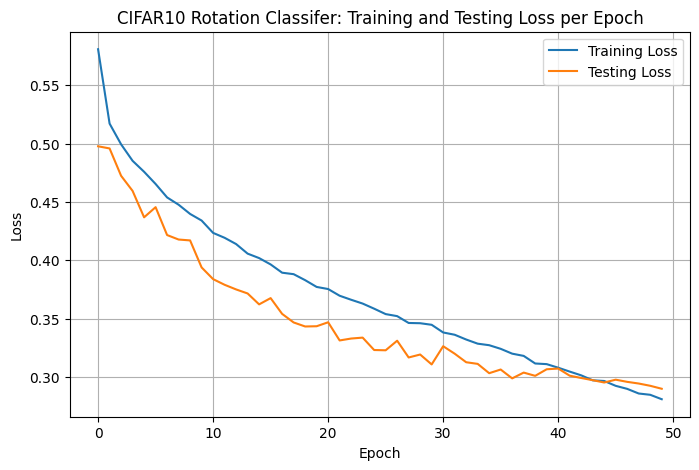

In [ ]:
model.eval()
correct = total = 0
with torch.no_grad():
    for x, _ in testset_loader_CIFAR10_R:
        
        labels_upright = torch.zeros(x.size(0), dtype=torch.long)

        images_rotated = torch.rot90(x, 1, [2, 3])
        labels_rotated = torch.ones(x.size(0), dtype=torch.long)

        all_images = torch.cat([x, images_rotated])
        all_labels = torch.cat([labels_upright, labels_rotated])
        
        # Transfer images to GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)
        
        # Move the images to the GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)

        # Get logits and sum up total loss
        logits = model(all_images)
        
        pred = logits.argmax(1)
        
        correct += (pred == all_labels).sum().item()
        total += all_labels.numel()

final_accuracy = float(correct / total)

print(f"Final Accuracy: {final_accuracy}")

epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10_R]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10_R]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10_R]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Rotation Classifer: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Results

Testing Accuracy: 87.015%

Training Loss: 0.2808

Testing Loss: 0.2898

#### Final Model Hyperparameters

epochs = 50

batch_size = 50

learning_rate = 5e-4

decay_rate = 1e-3

c_dropout = 0.30

f_dropout = 0.30

#### Model Architecture

For this problem, I am forced to maintain the original architecture for the best model that I found in Question 3. Of course, the final output layer is of size two for the two different classes to predict.

#### Initial Model Training

To start, I wanted to use different initial hyperparameters rather than the ones that I found for my model in Question 3 since I belived that doing so might allow me to learn more about my current model. As such, I used batch_size = 100, learning_rate = 1e-4, decay_rate = 5e-4, c_dropout = 0.10, and f_dropout = 0.10. For the first training loop, the model was able to achieve a training and testing loss of around 0.32 at the 11th epoch before it began to overfit. Unlike the previous models, the training and testing loss were pretty close to each other per epoch with not considerable gap, for the other models, the gap between the training and testing loss would be around 0.15 with the testing loss always being lower. Seeing this, I decided to go straight to tunning the dropout, from c_dropout = f_dropout = 0.10 to c_dropout = f_dropout = 0.20.

In the second trial, my model was only able to get a testing loss around 0.3180 at the 19th epoch before it began overfitting. Though, by the 4th epoch (around 0.40 loss), the model began learning way too slowly. At first, I wanted to change the dropout rate, but I wanted to fiddle around with the batch size a little bit more, so I decided to change the batch size from 100 to 125 first. Yet, this did not help as the model still was stuck at a similar loss. Decreasing the batch size to 50 gave me the same results, so I decided to move onto changing the learning rate.

For the fifth trial, I increased the learning rate from 1e-4 to 5e-4, and the model was able to get a testing loss = 0.3073 at the 17th epoch. By this point, I have started to notice that getting the loss lower than 0.25 would probably require better architecture. Seeing the results, I was satisfied with the learning rate, so I decided to once again change the dropouts since learning rate does not seem to be the reason as to why the model is learning slower.

In the sixth attempt, I changed the dropouts to be both 0.30 which let the model achieve a new minimum testing loss of 0.2960 at the 46th epoch. As can be seen, it seems the model requires a lot more training time at its current state. While it is training though, the training and testing losses decrement very slowly often with a minimal loss gap.

For my final change to training, I decided that I should try increasing the weight decay from 5e-4 to 1e-3 to see if it would benefit due to the model's slow training. From this change, my model was able to achieve a new testing loss of 0.2898 at the 50th epoch. I believed that increasing the weight decay would be helpful since the model training was very slow from the 0.35 loss range and below.



### Problem 5: Initialize a model, the same architecture as in Problem 3, where the first k layers initially have weight values copied from the same layers as the model in Problem 4. For each k, train this new model on the original classification task, and compare both final loss and total training to achieve that loss to the results in Problem 3. Do you see a benefit from weight transfer, and if so, how does it change with the layer? Why?

### Does it make a difference if you freeze the copied layers, or allow them to be trained as well?

In [6]:
def transfer_weights(model_final, model_src, k, is_frozen):
    
    for i in range(len(model_final.forward_funnel_1)):

        if k == 0: return

        src_layer = model_src.forward_funnel_1[i]
        final_layer = model_final.forward_funnel_1[i]

        if (hasattr(src_layer, 'weight') and hasattr(final_layer, 'weight')):
            final_layer.weight.data = src_layer.weight.data.clone()
            if is_frozen:
                final_layer.weight.requires_grad = False
            
            # This will always run if we get here. I do not intend on making layers with biases
            if (hasattr(src_layer, 'bias') and hasattr(final_layer, 'bias')):
                final_layer.bias.data = src_layer.bias.data.clone()
                if is_frozen:
                    final_layer.bias.requires_grad = False

                k -= 1

    
    for i in range(len(model_final.classifer)):
        
        if k == 0: return

        src_layer = model_src.classifer[i]
        final_layer = model_final.classifer[i]

        if (hasattr(src_layer, 'weight') and hasattr(final_layer, 'weight')):
            final_layer.weight.data = src_layer.weight.data.clone()
            if is_frozen:
                final_layer.weight.requires_grad = False
            
            # This will always run if we get here. I do not intend on making layers with biases
            if (hasattr(src_layer, 'bias') and hasattr(final_layer, 'bias')):
                final_layer.bias.data = src_layer.bias.data.clone()
                if is_frozen:
                    final_layer.bias.requires_grad = False

                k -= 1

In [ ]:
epoch_over_training_loss_CIFAR10_per_k = []
epoch_over_testing_loss_CIFAR10_per_k = []

'''
For of the data for this list is...

data = {
    k: int
    epoch: int
    training/testing loss: floats
    frozen: True or False
}

'''

In [ ]:
# Hyperparameter setup
epochs = 10
batch_size = 64
learning_rate = 5e-4
decay_rate = 4e-4

c_dropout = 0.25
f_dropout = 0.25

k = 8 # Max number of layers for the current model ~~ Excluding the output layer

# Initialize model for the sake of weight transfer
src_model = CIFAR10_Transformed_Classifier(c_dropout, f_dropout)
src_model.load_state_dict(torch.load('Q4_model_weights.pth'))


print('######## Begining training for CIFAR10 classifier + transfer learning ##########')

for i in range(2):
    
    is_frozen = True if i == 0 else False

    print(f':::: Training model with {'Frozen' if is_frozen else 'Unfrozen'} weights ::::\n')
    
    for current_k in range(1, k + 1, 1):
        
        print(f'\\_| Using {current_k} Transfered Layers |_/\n')
        
        # Setup data loaders
        trainset_loader_CIFAR10 = data.DataLoader(trainset_full_CIFAR10,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        # num_workers=5,
                                        pin_memory=True)

        testset_loader_CIFAR10 = data.DataLoader(testset_full_CIFAR10,
                                        batch_size=batch_size,
                                        # num_workers=5,
                                        shuffle=False,
                                        pin_memory=True)

        model_final = CIFAR10_Classifier(c_dropout, f_dropout)

        transfer_weights(model_final, src_model, k, is_frozen)

        model_final.to(device)

        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model_final.parameters(), 
                            lr=learning_rate, 
                            weight_decay=decay_rate
                            )

        # Have references to variables outside of the epoch loop
        avg_training_loss = 0
        avg_testing_loss = 0

        # Epoch Loop
        for epoch in range(epochs):
            print(f'----- Epoch: {epoch + 1}/{epochs} -----')
            
            avg_training_loss = 0
            avg_testing_loss = 0

            model_final.train()

            for x, _ in tqdm(trainset_loader_CIFAR10, desc='Training', unit=' batch'):

                labels_upright = torch.zeros(x.size(0), dtype=torch.long)

                images_rotated = torch.rot90(x, 1, [2, 3])
                labels_rotated = torch.ones(x.size(0), dtype=torch.long)

                all_images = torch.cat([x, images_rotated])
                all_labels = torch.cat([labels_upright, labels_rotated])
                
                
                # Transfer images to GPU
                all_images = all_images.to(device)
                all_labels = all_labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Send images to model
                x_pred = model_final(all_images)

                # Calc loss
                loss = loss_function(x_pred, all_labels)

                # Calc gradient and update weights
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    avg_training_loss += loss.item()

            # Switch to eval mode
            model_final.eval()

            with torch.no_grad():
                for x, _ in tqdm(testset_loader_CIFAR10, desc='Testing', unit=' batches'):
                    
                    labels_upright = torch.zeros(x.size(0), dtype=torch.long)

                    images_rotated = torch.rot90(x, 1, [2, 3])
                    labels_rotated = torch.ones(x.size(0), dtype=torch.long)

                    all_images = torch.cat([x, images_rotated])
                    all_labels = torch.cat([labels_upright, labels_rotated])
                    
                    # Transfer images to GPU
                    all_images = all_images.to(device)
                    all_labels = all_labels.to(device)
                    
                    # Move the images to the GPU
                    all_images = all_images.to(device)
                    all_labels = all_labels.to(device)

                    # Get logits and sum up total loss
                    x_pred = model_final(all_images)
                    avg_testing_loss += loss_function(x_pred, all_labels).item()

            # Get training loss
            avg_training_loss /= len(trainset_loader_CIFAR10)

            # Get testing loss
            avg_testing_loss /= len(testset_loader_CIFAR10)

            # Switch model back to training mode
            model_final.train()

            epoch_over_training_loss_CIFAR10_per_k.append({
                "k": current_k,
                "epoch": epoch,
                "training_loss": avg_training_loss,
                "frozen": is_frozen
                })
            
            epoch_over_testing_loss_CIFAR10_per_k.append({
                "k": current_k,
                "epoch": epoch,
                "testing_loss": avg_testing_loss,
                "frozen": is_frozen
                })
            

            print("")

            print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
            print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

    


In [9]:
import pandas as pd

# Convert to DataFrame and save as CSV
df_train = pd.DataFrame(epoch_over_training_loss_CIFAR10_per_k)
df_test = pd.DataFrame(epoch_over_testing_loss_CIFAR10_per_k)

df_train.to_csv('training_loss_per_k.csv', index=False)
df_test.to_csv('testing_loss_per_k.csv', index=False)

In [10]:
import pandas as pd

epoch_over_training_loss_CIFAR10_per_k = pd.read_csv('training_loss_per_k.csv').to_dict(orient='records')

epoch_over_testing_loss_CIFAR10_per_k = pd.read_csv('testing_loss_per_k.csv').to_dict(orient='records')

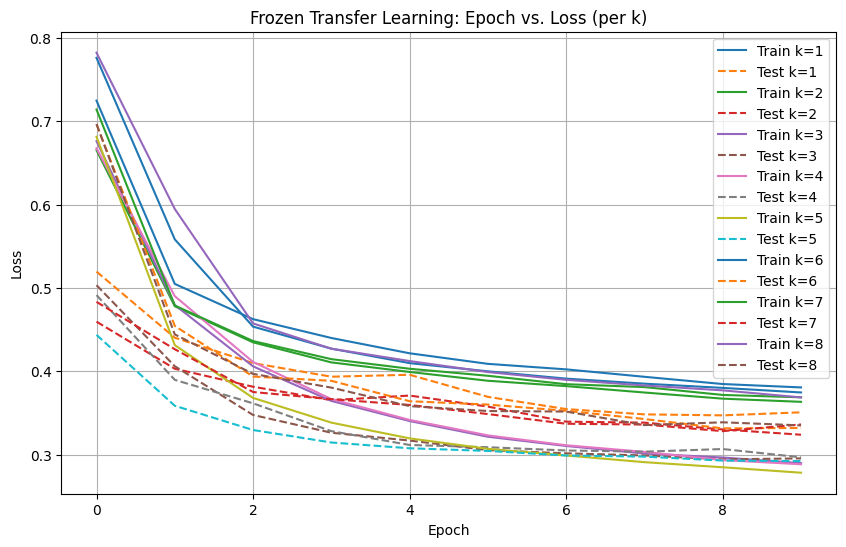

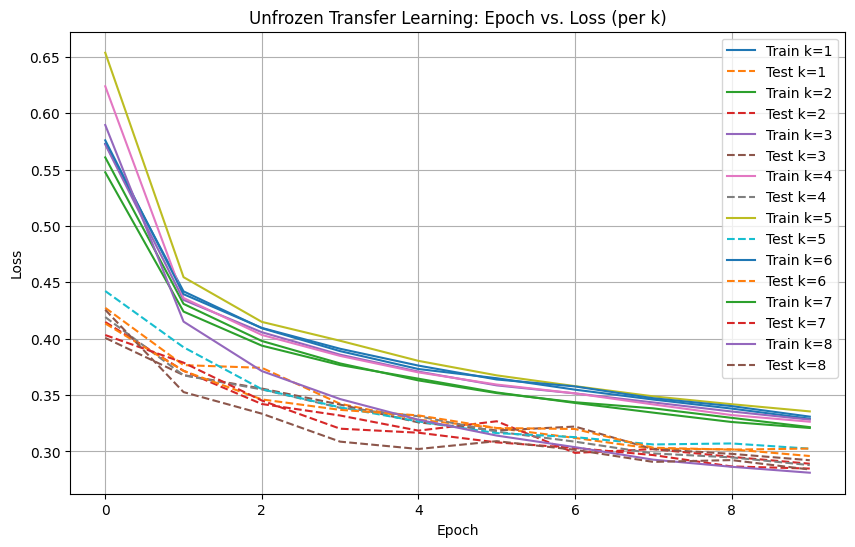

In [11]:
# Separate frozen and unfrozen runs
for frozen_status, title in zip([True, False], ["Frozen Transfer Learning", "Unfrozen Transfer Learning"]):
    plt.figure(figsize=(10, 6))
    ks = sorted(set(d["k"] for d in epoch_over_training_loss_CIFAR10_per_k if d["frozen"] == frozen_status))
    for k in ks:
        epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10_per_k if d["k"] == k and d["frozen"] == frozen_status]
        train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10_per_k if d["k"] == k and d["frozen"] == frozen_status]
        test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10_per_k if d["k"] == k and d["frozen"] == frozen_status]
        plt.plot(epochs, train_loss, label=f"Train k={k}")
        plt.plot(epochs, test_loss, '--', label=f"Test k={k}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + ": Epoch vs. Loss (per k)")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Result Analysis

From the graphs, I first notice that the overall losses, both training and testing, are all lower than the best losses I could get for my classifying model in Question 3. Moreover, training the model on all k's for the first epoch of data immediatly beats the initial classifier model. To me, this suggests that using any number of pre-learned layers would help the model achieve losses that it could not obtain previously. Interestingly, the weights that were transfered from the model in Question 4 were not trained to necessarily classify images but rather an image was rotated 90 degrees clockwise or not. From this, I believe that the model in Question 4 was able to learn how to classify the images to some degree which allowed it to tell whether the image was rotated. Another takeaway from this would be benefitial to train a model, with the same exactly architecture (excluding output layer), on a different problem on the same data so that we can use transfer learning to get better results then hyperparameter optimization alone.

Comparing the losses for both this model and Question 3's model, we can see that the final testing losses that the transfer learning models were able to achieve was between 0.34 to 0.25 in only 10 epochs. The old model was only able to get a final testing loss of around 0.80 at the 15th epoch. Taking into account that the new models were able to beat the old model in only one epoch and achieve very low losses in 10 epochs, I would say that the transfer learning not only trains the model's faster, but also allows them to be way more accurate. 

Taking a closer look at how k, the number of transfered layers, affects the model's performance, we can see that typically, the more layers are transfered, the lower the final testing loss is. Yet, the relationship is not exactly linear since we can see that some k's, like k = 5 comapred to k = 8 in the Frozen Model Graph, end up beating the final testing loss of higher k values. Additionally, higher k values end up overfitting the data more than lower k values. I believe this occurs since we are essentially limiting the number of layers that can learn new features that the transfered layers end up not finding.

Finally, from the graphs, we can see that it is better, maybe for just this dataset/problem, to keep the layers unfrozen since the overall training and testing losses over the epochs tends to be more stable and lower per k as compared to the frozen layer losses. For the context of this question, I believe this trend is justifiable since the model that we transfering layers from was only trying to find out whether an image was upright or rotated while Question 3's model is trying to classify images. It would be better to tune the weights we get so that they can better align with what were are trying to achieve, but seeing how low the losses were in intital training, we can certainly say that the rotation classifier model was able to learn very useful wieghts and biases.


### Problem 6: Formulate and conststruct an implementation of this problem. Train the model, and show that contrastive loss decreases. What does overfitting mean here, and how can you avoid it? Plot the initial embeddings of all images, color coded by their image class, and compare it to the embeddings after training. How does the network perform? Does it put similar things in similar locations? What about between classes?

In [32]:
class ContrastiveCIFAR10(data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = np.array(self.base_dataset.targets)

        # Pre-compute a dictionary mapping each class to a list of its indices
        self.labels_to_indices = {label: np.where(self.labels == label)[0]
                                  for label in set(self.labels)}

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        # Get the anchor image and its label
        img1, label1 = self.base_dataset[index]

        # Decide whether to sample a positive or negative pair (50% chance)
        is_similar = random.random() > 0.5

        if is_similar:
            # Positive pair: sample another image from the same class
            positive_indices = self.labels_to_indices[label1]
            # Make sure we don't pick the same image
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(positive_indices)
            img2, _ = self.base_dataset[positive_index]
            similarity = 1.0 # Similarity label is 1 for positive pairs
        else:
            # Negative pair: sample an image from a different class
            negative_label = np.random.choice(list(set(self.labels) - {label1}))
            negative_indices = self.labels_to_indices[negative_label]
            negative_index = np.random.choice(negative_indices)
            img2, _ = self.base_dataset[negative_index]
            similarity = 0.0 # Similarity label is 0 for negative pairs

        return img1, img2, torch.tensor(similarity, dtype=torch.float32)

In [33]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, similarity_label):
        # Calculate the euclidean distance squared between the embeddings
        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim=True)
        dist_sq = torch.pow(euclidean_distance, 2)

        # Loss for similar pairs (S=1): we want their distance to be small
        loss_similar = similarity_label * dist_sq

        # Loss for dissimilar pairs (S=0): we want their distance to be large, at least > margin
        # The loss is max(0, margin - distance)^2
        loss_dissimilar = (1 - similarity_label) * torch.pow(
            torch.clamp(self.margin - euclidean_distance, min=0.0), 2
        )

        # Combine the losses and average over the batch
        total_loss = torch.mean(loss_similar + loss_dissimilar)
        return total_loss

In [34]:
def get_all_embeddings(model, loader):
    model.eval()
    embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            embs = model(images).cpu().numpy()
            embeddings.append(embs)
            all_labels.append(labels.numpy())

    model.train()

    return np.concatenate(embeddings), np.concatenate(all_labels)

In [35]:
def plot_embeddings(embeddings, labels, title=""):
    plt.figure(figsize=(10, 8))
    class_names = trainset_full_CIFAR10.classes
    for i in range(len(class_names)):
        # Select embeddings that correspond to the current class
        inds = np.where(labels == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, label=class_names[i])
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
epoch_over_training_loss_CIFAR10_embedding = []
epoch_over_testing_loss_CIFAR10_embedding = []

'''
Form of the data is....
data ={
    epoch: int
    training/testing loss: float
}
'''

In [36]:
class CIFAR10_Encoder(nn.Module):
    def __init__(self, C_dropout, F_dropout, embedding_size=2):
        super().__init__()

        conv2d_dropout = C_dropout

        conv_layer_1 = 30
        conv_layer_2 = 64

        
        self.forward_funnel_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_layer_1, kernel_size=5),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_1, out_channels=conv_layer_2, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),                       # Reduce dimensionality
        )

        # Compute the number of features after the input has passed the funnel
        with torch.no_grad():
            test_input = torch.zeros(1, 3, 32, 32)

            test_input.to(device)

            features = self.forward_funnel_1(test_input)

            total_count = features.view(1, -1).size(1)

        full_node_dropout = F_dropout
        
        f_layer_1 = 500
        f_layer_2 = 250
        f_layer_3 = 100
        self.output_nodes = 50

        self.classifer = nn.Sequential(
            nn.Flatten(),                                           # Flatten the image from the funnel
            nn.Linear(in_features=total_count, out_features=f_layer_1), 
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=f_layer_1, out_features=f_layer_2),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=f_layer_2, out_features=f_layer_3),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=f_layer_3, out_features=self.output_nodes),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),
        )

        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=embedding_size)

    def forward(self, x):

        x = self.forward_funnel_1(x)
        x = self.classifer(x)

        logits = self.output_layer(x)

        return logits

In [ ]:
# Hyperparameter setup
epochs = 4
batch_size = 64
learning_rate = 5e-4
decay_rate = 0

c_dropout = 0.0
f_dropout = 0.0

embedding_model = CIFAR10_Encoder(c_dropout, f_dropout).to(device)
contrastive_loss_fn = ContrastiveLoss(margin=1.0)
optimizer = optim.AdamW(embedding_model.parameters(), lr=learning_rate, weight_decay=decay_rate)

contrastive_train_ds = ContrastiveCIFAR10(trainset_full_CIFAR10)
contrastive_train_loader = data.DataLoader(contrastive_train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           pin_memory=True)

contrastive_test_ds = ContrastiveCIFAR10(testset_full_CIFAR10)
contrastive_test_loader = data.DataLoader(contrastive_test_ds,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True)

print(f'######## Starting training of CIFAR10 embedding model ##########')

embedding_model.train()

for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')

    running_loss = 0.0
    for img1, img2, sim in tqdm(contrastive_train_loader, desc='Training', unit=' batchs'):
        img1, img2, sim = img1.to(device), img2.to(device), sim.to(device)

        optimizer.zero_grad()
        emb1, emb2 = embedding_model(img1), embedding_model(img2)
        loss = contrastive_loss_fn(emb1, emb2, sim)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    embedding_model.eval()

    testing_loss = 0.0

    with torch.no_grad():
        for img1, img2, sim in tqdm(contrastive_test_loader, desc='Test Validation', unit=' batches'):
            img1, img2, sim = img1.to(device), img2.to(device), sim.to(device)
            emb1, emb2 = embedding_model(img1), embedding_model(img2)

            loss = contrastive_loss_fn(emb1, emb2, sim)

            testing_loss += loss.item()

    testing_loss /= len(contrastive_test_loader)
    running_loss /= len(contrastive_train_loader)

    embedding_model.train()

    epoch_over_training_loss_CIFAR10_embedding.append({
        "epoch": epoch,
        "training_loss": running_loss
    })

    epoch_over_testing_loss_CIFAR10_embedding.append({
        "epoch": epoch,
        "testing_loss": testing_loss
    })

    print(f"  -> Training Loss: {running_loss:.4f}")
    print(f'  -> Testing Loss: {testing_loss:.4f}\n')

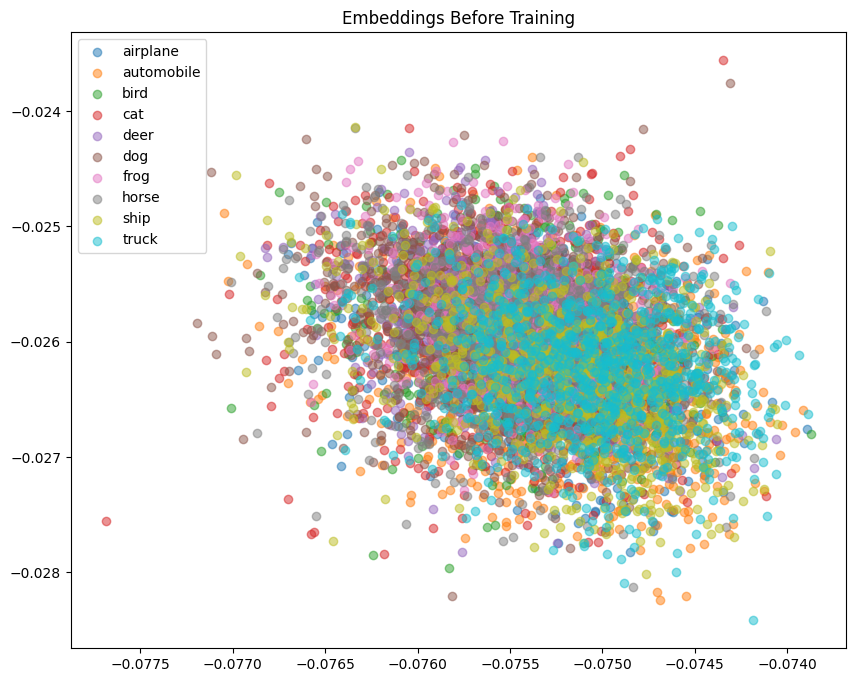

In [40]:
c_dropout = f_dropout = 0

dummy_model = CIFAR10_Encoder(c_dropout, f_dropout).to(device)
test_loader_vis = data.DataLoader(testset_full_CIFAR10, batch_size=batch_size, shuffle=False)

pretrained_embeddings, pretrained_labels = get_all_embeddings(dummy_model, test_loader_vis)
plot_embeddings(pretrained_embeddings, pretrained_labels, "Embeddings Before Training")

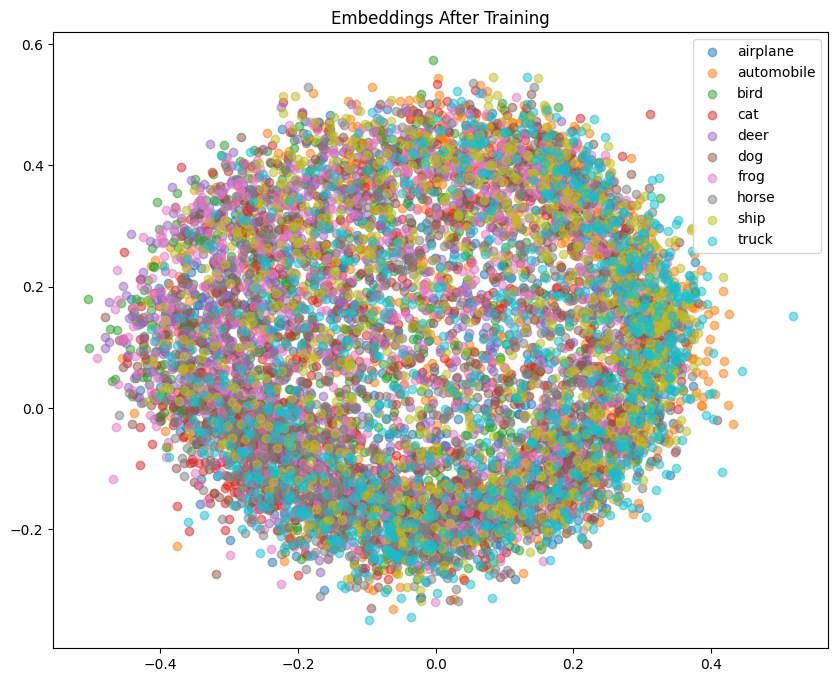

In [ ]:
final_embeddings, final_labels = get_all_embeddings(embedding_model, test_loader_vis)

plot_embeddings(final_embeddings, final_labels, "Embeddings After Training")

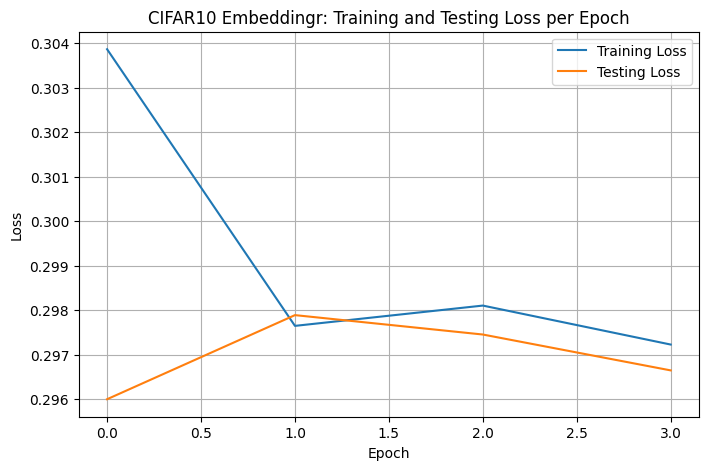

In [62]:
epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10_embedding]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10_embedding]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10_embedding]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Embeddingr: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Graph Analysis

Looking at the two graphs, we can see that after training, the model was able to separate the data better as compared to the untrained model. For instance, the untrained embeddings were all stacked on top of each other, kind of like a bucket full of data, but training was able to partially divide the data away from the center. Yet, after serious hyperparamter, model, and training tuning, I was unable to get the model to make meaningful embeddings. Most of the classes are kind of overlapped with each other, and in the middle of the trained embeddings graph, we can see that all classes are evenly spread out. Albeit this, there are certain classes that are grouped closer together in a meaningful way. For instance, the ship and truck classes are more closely grouped together on the edge of righthand side of the embedding space and most animals such as the dog, frog, and deer do the same but on the lefthand side of the embedding space. This tells me that the model was able to learn to some degree how to differential between most living and non-living classes in the data.

Overall, I would say that my model was only able to help embed the model classes partially in a meaningful way. Additionally, I would like to mention the effects of overfitting on this model. If the model is to be overtrained, then the model is only able to create meaningful embeddings on the training data, but will fail to do the same on the testing data. Visually, this means that the testing data would get embedded way too close to each other with no meaningful spacing. In fact, during training, I ran into this very issue and overtraining would give me a graph where the classes would be spaced in such a way that they model a thick linear line.


#### Final Model Architecture + Hyperparameters

2 convolutional layers of channels 30 and 64 and kernel size of 5 and 3 repsectively with a max pooling layer of size 2 and stride 2.

After the convolutional layers, there are four fully connected layers of sizes 500 -> 250 -> 100 -> 50 which finally connects to the output layer.

---


epochs = 4

batch_size = 64

learning_rate = 5e-4

decay_rate = 0

c_dropout = 0.0

f_dropout = 0.0


#### Model Architecture + Exploration

Initially, I decided that I wanted to keep the original architecture and hyperparameters from the model in Question 3 (2x(C-Layer -> C-Layer -> Max Pool) -> 5x(FC)), since it was used to classify images rather than image rotation, and just change the output layer to 2 nodes, however, on the first training loop, the model immediatly overfitted on the first epoch with a loss gap of around 0.20. As a result, when I graphed the embeddings, they ended up as a line with +1 slope. As such, I tried to remove the dropout and weight decay just to see what would happen and again, nothing changed. Because of this, I decided that I probably needed to change my architecture, so I decided to remove two convolutional layers. After another attempt of training, the overfitting gap between the losses was around 0.10 less but was still present, so I finally removed a second convolutional layer which allowed me to get a testing and training loss around 0.30. As one final step, I decided to change the number of channels from 30 -> 64 to 30 -> 128 in order to allow the model to learn more complex relationships with the data, something which was lost when I removed the two other layers. Even still, this allowed my losses to remain at the 0.30 range no matter the epoch.

As I tried to find new hyperparameters for my new architecture, I was unable to find any combination that allowed the model loss to get lower than 0.29. During training, the model would tend to just stagnate between 0.295 to 0.3010 loss and not end up learning. If I tried to increase my learning rate to 1e-2 and beyond, the model loss would explode into the thousands. Seeing this, I decided to change the number of convolutional channels from 30 -> 128 to 30 -> 200 to see if adding more feature capacity would do anything, but nothing changed. As such, I began to use the old hyperparameters again.

For my next change, I decided to increase the size of the fully connected layers from 1000 -> 500 -> 250 -> 100 to 5000 -> 2500 -> 1000 -> 500 since maybe increasing the size could give the model more headroom to learn. Other than making model training time longer, I was still unable to get past 0.29 loss. Next, I decided to use the reverse logic and decrease the number of channels in my convolution layers from 30 -> 128 to 30 -> 50. Again, no loss minimum was broken.

As one final test, I wanted to see if just increasing the size of the model once again would yield any sort of better results. The model's convolutional layers' channels went from 30 -> 50 to 64 -> 128 and the fully connected layers went from 5000 -> 2500 -> 1000 -> 500 to 10000 -> 5000 -> 2500 -> 1000, and to my dismay, the behavior of model training was still the same as it would oscilate from around 0.31 to 0.295. 

In order to have a final graph, I decided to lower my model size back to 30 -> 64, convolutional layers, and 500 -> 250 -> 100 -> 50 and was able to achieve a final testing loss of 0.2966 at the 4th epoch.